#### [예제 3-6] 옷 종류 데이터 FashionMNIST를 활용해 AutoEncoder 설계하기

#### 1. Module Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

#### 2. Using GPU

In [2]:
#2. 딥러닝 모델을 설계할 때 활용하는 cuda 확인
if torch.cuda.is_available():
    DEVICE = torch.device('cuda:0')
else :
    DEVICE = torch.device('cpu')
    
print('Using PyTorch version : ', torch.__version__, '  Device : ', DEVICE)

Using PyTorch version :  1.8.0   Device :  cuda:0


In [3]:
BATCH_SIZE = 32
EPOCHS = 10

In [4]:
train = datasets.FashionMNIST(root='../data/FashionMNIST',train=True,
                             download=True, transform = transforms.ToTensor())
test = datasets.FashionMNIST(root='../data/FashionMNIST',train=False,
                            transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset=train,
                                          batch_size = BATCH_SIZE,
                                          shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset=test,
                                         batch_size=BATCH_SIZE,
                                         shuffle = False)


Extracting ../data/FashionMNIST\FashionMNIST\raw\train-images-idx3-ubyte.gz to ../data/FashionMNIST\FashionMNIST\raw



Extracting ../data/FashionMNIST\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ../data/FashionMNIST\FashionMNIST\raw



Extracting ../data/FashionMNIST\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ../data/FashionMNIST\FashionMNIST\raw



Extracting ../data/FashionMNIST\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST\FashionMNIST\raw
Processing...


C:\Users\HeoJiHae\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:479: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


#### 3. Confirm Data

In [5]:
for (X_train, y_train) in train_loader :
    print("X_train", X_train.shape, "y_train", y_train.shape)
    break

X_train torch.Size([32, 1, 28, 28]) y_train torch.Size([32])


In [6]:
for (X_test, y_test) in test_loader :
    print("X_test", X_test.shape, "y_test", y_test.shape)
    break

X_test torch.Size([32, 1, 28, 28]) y_test torch.Size([32])


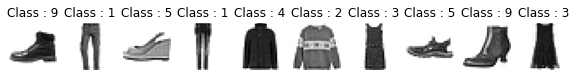

In [8]:
pltsize = 1
plt.figure(figsize=(10*pltsize, pltsize))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(X_train[i,:,:,:].numpy().reshape(28,28), cmap="gray_r")
    plt.title('Class : '+str(y_train[i].item()))

#### 4. AutoEncoder(AE) Model Design

In [10]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        
        self.encoder = nn.Sequential(
        nn.Linear(28*28, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 32),)
        
        self.decoder = nn.Sequential(
        nn.Linear(32, 256),
        nn.ReLU(),
        nn.Linear(256, 512),
        nn.ReLU(),
        nn.Linear(512, 28*28),)
        
    def forward(self, x): #(1) : 인코더와 디코더에 대한 forward propagation 계산        
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

https://excelsior-cjh.tistory.com/187

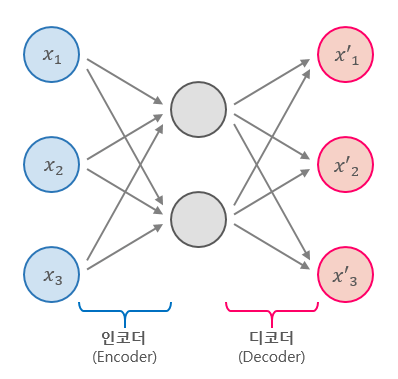

AutoEncoder(AE)는 encoder와 decoder로 이루어져 있는데 단순히 입력을 출력으로 복사하는 신경망이다. 네트워크에 여러가지 방법으로 제약을 줌으로써 어려운 신경망을 만든다.

#### 5. Optimizer, Objective Function Setting

In [11]:
model = AE().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

print(model)

AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
  )
)


Optimizer = Back Propagation을 통해 파라미터를 업데이트 할 때 이용되는 함수 정의

In [13]:
def train(model,train_loader, optimizer,log_interval):
    model.train()
    for batch_idx, (image,_) in enumerate(train_loader): 
        image = image.view(-1, 28*28).to(DEVICE) # (1)
        target = image.view(-1, 28*28).to(DEVICE) # (2)
        optimizer.zero_grad() 
        encoded, decoded = model(image)
        loss = criterion(decoded, target)
        loss.backward() 
        optimizer.step() 
        
        if batch_idx % log_interval == 0 :
            print("Train Epoch : {} [{}/{}({:.0f}%)] Train Loss : {:.6f}".format(
            Epoch, batch_idx * len(image),
            len(train_loader.dataset), 100.* batch_idx / len(train_loader),
            loss.item()))

(1) : Mini-batch 내에 있는 이미지 데이터를 기존에 정의한 장비에 할당한다. 이때 기존에 정의한 Auto Encoder의 Input은 28* 28 크기의 1차원 레이어이므로 2차원 이미지 데이터를 1차원 데이터로 재구성 해야한다.

(2) : Mini-batch 내에 있는 이미지 데이터를 AE 의 Output과 비교하는 대상으로 설정하기 위해 기존에 정의한 장비에 할당한다. 이때도 마찬가지로 1차원 데이터로 재구성 해야한다.

#### 6. Check Model Performance

In [14]:
def evaluate(model,test_loader):
    model.eval()
    test_loss = 0
    real_image = []
    gen_image = []
    
    with torch.no_grad(): 
        for image, _ in test_loader:
            image = image.view(-1, 28*28).to(DEVICE) 
            target = image.view(-1, 28*28).to(DEVICE)
            encoded, decoded = model(image)
            test_loss += criterion(decoded, image).item()
            real_image.append(image.to("cpu"))
            gen_image.append(decoded.to("cpu"))
            
    test_loss /= len(test_loader.dataset)
    return test_loss, real_image, gen_image 

#### 7. Run training and check for errors in the test set

Train Epoch : 1 [0/60000(0%)] Train Loss : 0.010734
Train Epoch : 1 [6400/60000(11%)] Train Loss : 0.008792
Train Epoch : 1 [12800/60000(21%)] Train Loss : 0.011687
Train Epoch : 1 [19200/60000(32%)] Train Loss : 0.011693
Train Epoch : 1 [25600/60000(43%)] Train Loss : 0.007961
Train Epoch : 1 [32000/60000(53%)] Train Loss : 0.012301
Train Epoch : 1 [38400/60000(64%)] Train Loss : 0.010247
Train Epoch : 1 [44800/60000(75%)] Train Loss : 0.013112
Train Epoch : 1 [51200/60000(85%)] Train Loss : 0.009828
Train Epoch : 1 [57600/60000(96%)] Train Loss : 0.011328
|n[EPOCH :1], Test Loss : 0.0003 


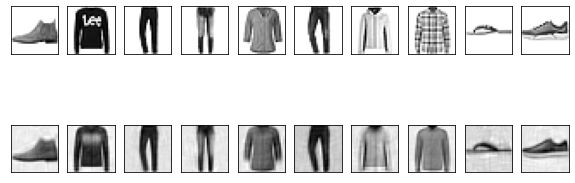

Train Epoch : 2 [0/60000(0%)] Train Loss : 0.008814
Train Epoch : 2 [6400/60000(11%)] Train Loss : 0.010907
Train Epoch : 2 [12800/60000(21%)] Train Loss : 0.008985
Train Epoch : 2 [19200/60000(32%)] Train Loss : 0.010471
Train Epoch : 2 [25600/60000(43%)] Train Loss : 0.008617
Train Epoch : 2 [32000/60000(53%)] Train Loss : 0.006471
Train Epoch : 2 [38400/60000(64%)] Train Loss : 0.009759
Train Epoch : 2 [44800/60000(75%)] Train Loss : 0.009589
Train Epoch : 2 [51200/60000(85%)] Train Loss : 0.010800
Train Epoch : 2 [57600/60000(96%)] Train Loss : 0.008234
|n[EPOCH :2], Test Loss : 0.0003 


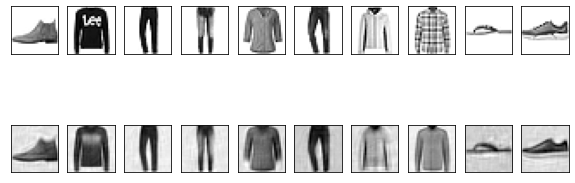

Train Epoch : 3 [0/60000(0%)] Train Loss : 0.011216
Train Epoch : 3 [6400/60000(11%)] Train Loss : 0.009789
Train Epoch : 3 [12800/60000(21%)] Train Loss : 0.010868
Train Epoch : 3 [19200/60000(32%)] Train Loss : 0.008546
Train Epoch : 3 [25600/60000(43%)] Train Loss : 0.007580
Train Epoch : 3 [32000/60000(53%)] Train Loss : 0.009714
Train Epoch : 3 [38400/60000(64%)] Train Loss : 0.010917
Train Epoch : 3 [44800/60000(75%)] Train Loss : 0.008771
Train Epoch : 3 [51200/60000(85%)] Train Loss : 0.010473
Train Epoch : 3 [57600/60000(96%)] Train Loss : 0.010418
|n[EPOCH :3], Test Loss : 0.0003 


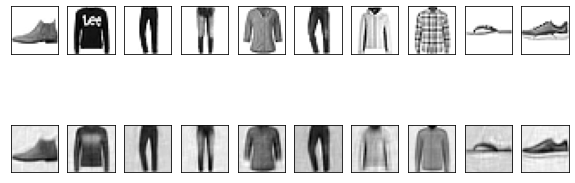

Train Epoch : 4 [0/60000(0%)] Train Loss : 0.010652
Train Epoch : 4 [6400/60000(11%)] Train Loss : 0.009304
Train Epoch : 4 [12800/60000(21%)] Train Loss : 0.010250
Train Epoch : 4 [19200/60000(32%)] Train Loss : 0.009045
Train Epoch : 4 [25600/60000(43%)] Train Loss : 0.008236
Train Epoch : 4 [32000/60000(53%)] Train Loss : 0.008956
Train Epoch : 4 [38400/60000(64%)] Train Loss : 0.010831
Train Epoch : 4 [44800/60000(75%)] Train Loss : 0.009662
Train Epoch : 4 [51200/60000(85%)] Train Loss : 0.010135
Train Epoch : 4 [57600/60000(96%)] Train Loss : 0.007668
|n[EPOCH :4], Test Loss : 0.0003 


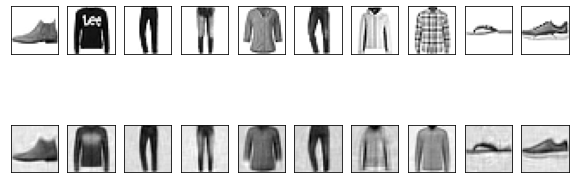

Train Epoch : 5 [0/60000(0%)] Train Loss : 0.010346
Train Epoch : 5 [6400/60000(11%)] Train Loss : 0.010252
Train Epoch : 5 [12800/60000(21%)] Train Loss : 0.009548
Train Epoch : 5 [19200/60000(32%)] Train Loss : 0.008810
Train Epoch : 5 [25600/60000(43%)] Train Loss : 0.009909
Train Epoch : 5 [32000/60000(53%)] Train Loss : 0.009498
Train Epoch : 5 [38400/60000(64%)] Train Loss : 0.008589
Train Epoch : 5 [44800/60000(75%)] Train Loss : 0.008520
Train Epoch : 5 [51200/60000(85%)] Train Loss : 0.007700
Train Epoch : 5 [57600/60000(96%)] Train Loss : 0.010822
|n[EPOCH :5], Test Loss : 0.0003 


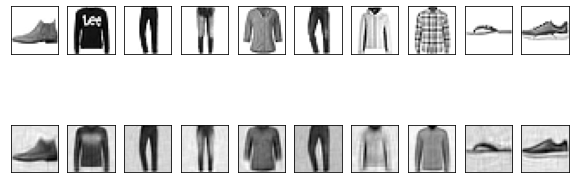

Train Epoch : 6 [0/60000(0%)] Train Loss : 0.010757
Train Epoch : 6 [6400/60000(11%)] Train Loss : 0.008811
Train Epoch : 6 [12800/60000(21%)] Train Loss : 0.007274
Train Epoch : 6 [19200/60000(32%)] Train Loss : 0.010498
Train Epoch : 6 [25600/60000(43%)] Train Loss : 0.009038
Train Epoch : 6 [32000/60000(53%)] Train Loss : 0.009430
Train Epoch : 6 [38400/60000(64%)] Train Loss : 0.007954
Train Epoch : 6 [44800/60000(75%)] Train Loss : 0.009858
Train Epoch : 6 [51200/60000(85%)] Train Loss : 0.008908
Train Epoch : 6 [57600/60000(96%)] Train Loss : 0.008965
|n[EPOCH :6], Test Loss : 0.0003 


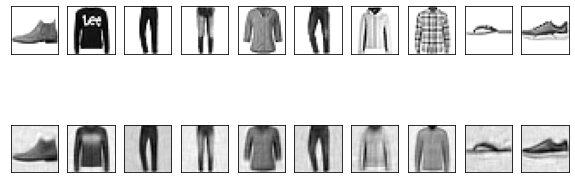

Train Epoch : 7 [0/60000(0%)] Train Loss : 0.010047
Train Epoch : 7 [6400/60000(11%)] Train Loss : 0.010335
Train Epoch : 7 [12800/60000(21%)] Train Loss : 0.010119


In [ ]:
for Epoch in range(1, EPOCHS+1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, real_image, gen_image = evaluate(model, test_loader)
    print("|n[EPOCH :{}], Test Loss : {:.4f} ".
         format(Epoch, test_loss))
    
    f,a = plt.subplots(2,10,figsize=(10,4))
    for i in range(10):
        img = np.reshape(real_image[0][i],(28,28))
        a[0][i].imshow(img, cmap="gray_r")
        a[0][i].set_xticks(())
        a[0][i].set_yticks(())
        
    for i in range(10):
        img = np.reshape(gen_image[0][i],(28,28))
        a[1][i].imshow(img, cmap="gray_r")
        a[1][i].set_xticks(())
        a[1][i].set_yticks(())
        
    plt.show()